In [1]:
#In this code I'm going to see if we can train a NN from one game and have it predict positions from the next game
#Importing the libraries
from data_loader import FootballDataLoader
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow import keras
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, SimpleRNN, LSTM, GRU
import pickle
import os
import matplotlib.pyplot as plt
from ML_Functions_LoadArrays import *
import numpy as np


2025-05-28 08:06:41.535758: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-28 08:06:41.540474: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 08:06:41.575882: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-28 08:06:41.610750: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1748412401.642506   20492 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1748412401.65

In [ ]:
def get_xy_from_XG(XGPos1, XGPos2, team):
    if team == 'AAB':
        x = np.array(XGPos1, dtype=float) / 100 * 105 - 52.5  
        y = np.array(XGPos2, dtype=float) / 100 * 70 - 35
    elif team in ['AGF', 'BIF', 'FCK', 'FCN',  'SIF', 'SJE', 'VFF']:
        x = np.array(XGPos1, dtype=float) / 100 * 105 - 52.5  
        y = np.array(XGPos2, dtype=float) / 100 * 68 - 34
    elif team == 'FCM':
        x = np.array(XGPos1, dtype=float) / 100 * 104 - 52  
        y = np.array(XGPos2, dtype=float) / 100 * 65 - 32.5
    elif team in ['LYN', 'RFC']:
        x = np.array(XGPos1, dtype=float) / 100 * 102 - 51  
        y = np.array(XGPos2, dtype=float) / 100 * 65 - 32.5
    elif team == 'VB':
        x = np.array(XGPos1, dtype=float) / 100 * 108 - 54
        y = np.array(XGPos2, dtype=float) / 100 * 68 - 34
    return x, y

def get_shot_time(times_x, t, Us, Ball, XGNumbers, XGPos1, XGPos2, i, verbose=False):
    passed = False
    idxs = np.where(np.isclose(times_x, t, atol=0.03)) #I believe when XGDat says 50 seconds, it means the shot took place between 49-50 seconds, research shows this is usually true, but sometimes the time in XGData is 3 seconds off...
    if len(idxs[0]) == 0:
        if verbose:
            print(f"Warning: No close time found for {t} in times_x.")
        return 0, passed
    idxs = idxs[0][0]  # Get the first index where the time is close
    frames = np.arange(max(0 , idxs-40), min(len(Us), idxs+15)) #So we take the whole second, and also half a second before and after, so we take from 48.5-50.5
    for idx in frames:
        if Ball[idx][5] == 0:
             frames = np.delete(frames, np.where(frames == idx)) #take only the idx in which the ball is being played

    if len(frames) == 0: 
        if verbose:
            print(f"Ball not being played.")
        return 0, passed
    
    else:
        shooter = int(XGNumbers[i])
        shooter_x = float(XGPos1[i])
        shooter_y = float(XGPos2[i])
        #print(shooter, shooter_x, shooter_y, t/60)
        shooter_pos_in_data = next((j for j, player_data in enumerate(Us[frames[0]]) if int(player_data[4]) == shooter), None)

        if shooter_pos_in_data is None:
            if verbose:
                print(f"Warning: player {shooter} not found in Us[{frames[0]}]")
            return 0, passed


        distances = np.array([np.sqrt((Us[idx][shooter_pos_in_data][0] - Ball[idx][0])**2 + (Us[idx][shooter_pos_in_data][1] - Ball[idx][1])**2) for idx in frames])
        mask = ((np.abs(np.array([Us[idx][shooter_pos_in_data][0] for idx in frames]) - shooter_x) <= 1.5) &
                (np.abs(np.array([Us[idx][shooter_pos_in_data][1] for idx in frames]) - shooter_y) <= 1.5))
        distances = distances[mask]

        if len(distances) == 0:
            if verbose:
                print(f"Warning: player {shooter} not found in Us[{frames[0]}] within 1.5m of where the player is supposed to be.")
            return 0, passed
        
        else : 
            if min(distances) > 2:
                if verbose:
                    print("Ball - Shooter distance > 2")
                return 0, passed
            passed = True
            if verbose:
                print(f"Shot time found at frame {frames[np.argmin(distances)]} with distance {min(distances)}")
            return frames[np.argmin(distances)], passed
    

def get_sequence(Team, verbose=False):
    broken_NamesSC = ['Game_SJE_BIF_Score_2_2_Day_2024-11-24Z.pkl', 'Game_SJE_VFF_Score_2_2_Day_2024-09-01Z.pkl', 'Game_SJE_FCN_Score_1_4_Day_2024-10-06Z.pkl']
    NamesXG, NamesSC = SortGames('pippo', Team)
    columns = ['XG', 'Time', 'Half','ball_x', 'ball_y', 'ball_z', 'ball_speed']
    for i in range(1, 12):
        columns += [f'us_{i}_x', f'us_{i}_y', f'us_{i}_speed']
    for i in range(1, 12):
        columns += [f'them_{i}_x', f'them_{i}_y', f'them_{i}_speed']

    distances_list = []
    rows = []
    for igame in range(30):
        if NamesSC[igame] not in broken_NamesSC:
            Time, Ball, Us, Them = SecLoad(Team, NamesSC, igame)

            XGNumbers, XGTeam, XGValue, XGHalf, XGMin, XGSec, XGTimes, XGPos1, XGPos2 = (
                MacihneLearning_OptaLoad(Team, NamesXG, igame)
            )

            XG_x, XG_y = get_xy_from_XG(XGPos1, XGPos2, NamesSC[igame].split('_')[1])  # Assuming the pitch size is based on the team name in the file

            times_x = np.array([t[0] for t in Time])
            XGs = []
            for i, t in enumerate(XGTimes):
                if XGTeam[i] == Team and XGValue[i] > 0:
                    xg_moment = XGValue[i]
                    idxs = np.where(np.isclose(times_x, t, atol=0.03))[0][0] #I believe when XGDat says 50 seconds, it means the shot took place between 49-50 seconds
                    frames = np.arange(max(0 , idxs-40), min(len(Us), idxs+15)) #So we take the whole second, and also half a second before and after, so we take from 48.5-50.5
                    for idx in frames:
                        if Ball[idx][5] == 0:
                            frames = np.delete(frames, np.where(frames == idx))
                    if len(frames) != 0:

                        idx, passed = get_shot_time(times_x, t, Us, Ball, XGNumbers, XG_x, XG_y, i, verbose=verbose)

                        if passed:

                            distances = np.array([np.sqrt((Us[idx][j][0] - Ball[idx][0])**2 + (Us[idx][j][1] - Ball[idx][1])**2) for j in range(len(Us[idx]))])
                        
                            distances_list.append(min(distances))
                            index_ordered = np.argsort(distances)
                            Us[idx] = Us[idx][index_ordered]
                            distances = np.array([np.sqrt((Them[idx][j][0] - Ball[idx][0])**2 + (Them[idx][j][1] - Ball[idx][1])**2) for j in range(len(Them[idx]))])
                            index_ordered = np.argsort(distances)
                            Them[idx] = Them[idx][index_ordered]
                            # Player on the filed

                            frames_definig_play = np.arange(max(0 , idxs-125), idx) 
                            Ball_values = np.array([Ball[frame][5] for frame in frames_definig_play])
                            find_stop = np.where(Ball_values == 0)[0][-1] if np.any(Ball_values == 0) else None
                            if find_stop is not None:
                                frames_definig_play = frames_definig_play[find_stop:]

                            for time in frames_definig_play : 
                                row = {}
                                row['XG'] = xg_moment
                                row['Time'] = Time[time][0]
                                row['Half'] = XGHalf[i]
                                row['ball_x'] =  abs(Ball[time][0])
                                row['ball_y'] =  Ball[time][1]
                                row['ball_z'] =  Ball[time][2]
                                row['ball_speed'] =  Ball[time][3]
                                for j in range(len(Us[time])):
                                    row[f'us_{j+1}_x'] = Us[time][j][0]*np.sign(Ball[time][0])
                                    row[f'us_{j+1}_y'] = Us[time][j][1]
                                    row[f'us_{j+1}_speed'] = Us[time][j][3]
                                for j in range(len(Them[time])):    
                                    row[f'them_{j+1}_x'] = Them[time][j][0]*np.sign(Ball[time][0])
                                    row[f'them_{j+1}_y'] = Them[time][j][1]
                                    row[f'them_{j+1}_speed'] = Them[time][j][3]
                                # Filling the rest of the row with NaN
                                if len(Us[time]) < 11:
                                    for j in range(len(Us[time]), 11):
                                        row[f'us_{j+1}_x'] = np.nan
                                        row[f'us_{j+1}_y'] = np.nan
                                        row[f'us_{j+1}_speed'] = np.nan
                                if len(Them[time]) < 11:
                                    for j in range(len(Them[time]), 11):
                                        row[f'them_{j+1}_x'] = np.nan
                                        row[f'them_{j+1}_y'] = np.nan
                                        row[f'them_{j+1}_speed'] = np.nan
                                rows.append(row)
                            XGs.append(XGValue[i])
                            

    total_XG_data = pd.DataFrame(rows, columns=columns)
    return total_XG_data, XGs

dist_l = []
tXG_all, Xgs = get_sequence('AAB', verbose=False) #1 team takes +- 1 min,  
print("Team AAB done")

for team in ['AGF', 'BIF', 'FCK', 'FCM', 'FCN', 'LYN', 'RFC', 'SIF', 'SJE', 'VB', 'VFF']:
    tXG, d_l = get_sequence(team) 
    print(f"Team {team} done")
    dist_l += d_l
    tXG_all = pd.concat([tXG_all, tXG], ignore_index=True)
print(tXG_all.shape)


LEN 30


Exception ignored in: <bound method IPythonKernel._clean_thread_parent_frames of <ipykernel.ipkernel.IPythonKernel object at 0x78106bfc3530>>
Traceback (most recent call last):
  File "/home/francesco/.local/lib/python3.12/site-packages/ipykernel/ipkernel.py", line 775, in _clean_thread_parent_frames
    def _clean_thread_parent_frames(

KeyboardInterrupt: 


In [2]:
tXG_all = pd.read_csv('XGData_forNN.csv')


In [30]:
train_positions = tXG_all.drop(tXG_all.columns[[0, 2]], axis=1)

# Suddividi il dataset in base al valore esatto di XG, raggruppando per valore
xg_groups = {}
for xg_value in tXG_all['XG'].unique():
    xg_groups[xg_value] = tXG_all[tXG_all['XG'] == xg_value]

train_X = []
train_y = []
appo = []

for xg_val, group_df in xg_groups.items():
    appo = []
    for i in range((group_df.shape[0])-1 , -1 , -5):
        appo.append(group_df.drop(tXG_all.columns[[0, 2]], axis=1).iloc[i].values)
    appo = np.array(appo)
    appo = np.flip(appo, axis=0)  # Flip the sequence
    train_X.append(np.array(appo))
    train_y.append(xg_val)


train_X = np.array(train_X, dtype=object)
train_y = np.array(train_y, dtype=float)

In [31]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

maxlen = max([seq.shape[0] for seq in train_X])

train_X_padded = pad_sequences(train_X, maxlen=maxlen, dtype='float32', padding='post')
train_y = np.nan_to_num(train_y, nan=0.0, posinf=0.0, neginf=0.0)

num_samples, timesteps, num_features = train_X_padded.shape
scaler = StandardScaler()
train_X_padded = scaler.fit_transform(train_X_padded.reshape(-1, num_features)).reshape(num_samples, timesteps, num_features)
train_X_padded = np.nan_to_num(train_X_padded, nan=0.0, posinf=0.0, neginf=0.0)

In [43]:
X_train, X_test, y_train, y_test = train_test_split(
    train_X_padded, train_y, test_size=0.2, random_state=42
)
print("NaN in train_X_padded:", np.isnan(train_X_padded).any())
print("NaN in train_y:", np.isnan(train_y).any())
print("Inf in train_X_padded:", np.isinf(train_X_padded).any())
print("Inf in train_y:", np.isinf(train_y).any())

model = Sequential()
model.add(GRU(64, input_shape=(maxlen, train_X_padded.shape[2]), return_sequences=True))
model.add(GRU(32, return_sequences=False)) 
model.add(Dropout(0.3))
model.add(Dense(32, activation='relu'))
model.add(Dense(1, activation='sigmoid'))  

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

model.fit(X_train, train_y, epochs=50, batch_size=64, validation_split=0.2 , verbose=1)

# Evaluate the model
loss, mae = model.evaluate(X_test, y_test)
print(f"Test Loss: {loss}, Test MAE: {mae}")
# Plot predictions vs actual values
predictions = model.predict(X_test)


NaN in train_X_padded: False
NaN in train_y: False
Inf in train_X_padded: False
Inf in train_y: False
Epoch 1/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - loss: 0.0948 - mae: 0.2734 - val_loss: 0.0276 - val_mae: 0.0923
Epoch 2/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0270 - mae: 0.1006 - val_loss: 0.0315 - val_mae: 0.0905
Epoch 3/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0339 - mae: 0.0996 - val_loss: 0.0285 - val_mae: 0.0898
Epoch 4/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0327 - mae: 0.1071 - val_loss: 0.0267 - val_mae: 0.1038
Epoch 5/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 0.0286 - mae: 0.1160 - val_loss: 0.0270 - val_mae: 0.0969
Epoch 6/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0290 - mae: 0.1063 - val_loss: 0.0274 - val_mae: 0.0935
Epoch 7/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 0.0342 - mae: 0.1130 - val_loss: 0.0270 - val_mae: 0.0975
Epoch 8/50
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0312 - mae: 0.1120

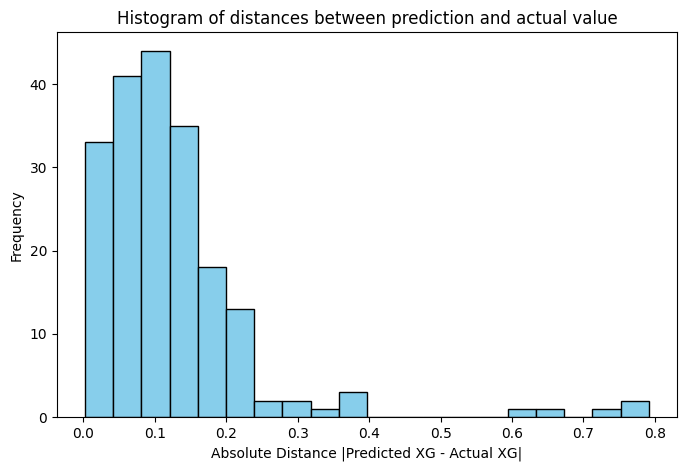

In [44]:
distanze = np.abs(predictions.flatten() - y_test)

plt.figure(figsize=(8, 5))
plt.hist(distanze, bins=20, color='skyblue', edgecolor='black')
plt.xlabel('Absolute Distance |Predicted XG - Actual XG|')
plt.ylabel('Frequency')
plt.title('Histogram of distances between prediction and actual value')
plt.show()

Text(0, 0.5, 'Loss')

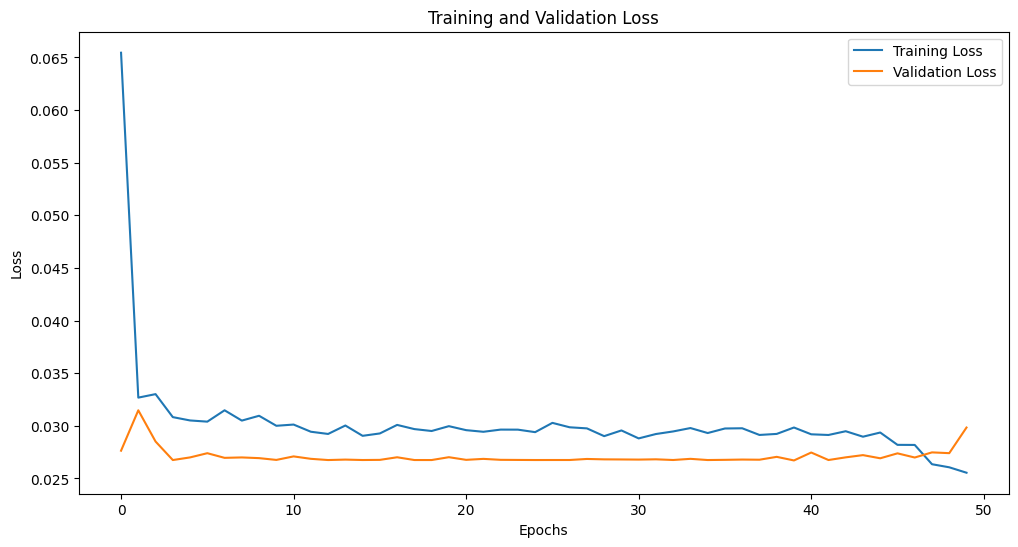

In [45]:
#Plot training history
history = model.history.history
plt.figure(figsize=(12, 6))
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss') 
plt.legend()  
plt.xlabel('Epochs')
plt.ylabel('Loss')